# Combined dataset

I already have the created dataset, I will do a quick EDA to see how the data looks and if it is suitable for further processing.

In [ ]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
source_dir = Path("../data/processed/merged/merged_all_years.csv")

In [3]:
df = pd.read_csv(source_dir)
df.head()

,year,month,day,hour,day_of_week,holiday,before_holiday,consumption,temperature_2m,wind_gusts_10m,...,cloud_cover_low,cloud_cover_mid,cloud_cover_high,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth
0,2013,1,1,0,1,1,0,309647.0,-1.023,14.400000,...,0.0,0.0,48.0,79.183050,-4.173,-4.679780,0.0,0.0,0.0,0.0
1,2013,1,1,1,1,1,0,317580.0,-1.523,14.040000,...,0.0,0.0,54.0,78.808304,-4.723,-5.289084,0.0,0.0,0.0,0.0
2,2013,1,1,2,1,1,0,306847.0,-1.923,13.320000,...,0.0,2.0,67.0,79.044044,-5.073,-5.911498,0.0,0.0,0.0,0.0
3,2013,1,1,3,1,1,0,311308.0,-2.123,12.959999,...,0.0,14.0,50.0,78.714120,-5.323,-6.189627,0.0,0.0,0.0,0.0
4,2013,1,1,4,1,1,0,313706.0,-2.273,12.959999,...,0.0,41.0,3.0,78.392360,-5.523,-6.195621,0.0,0.0,0.0,0.0


In [4]:
print("\n".join(df.columns.tolist()))

year
month
day
hour
day_of_week
holiday
before_holiday
consumption
temperature_2m
wind_gusts_10m
wind_direction_100m
wind_direction_10m
wind_speed_100m
wind_speed_10m
weather_code
pressure_msl
surface_pressure
cloud_cover
cloud_cover_low
cloud_cover_mid
cloud_cover_high
relative_humidity_2m
dew_point_2m
apparent_temperature
precipitation
rain
snowfall
snow_depth


# Data Overview & Cleaning

In [5]:
# Basic dataset info and robust datetime handling
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# If datetime missing or not datetime dtype, build it from year/month/day/hour
if 'datetime' not in df.columns or not np.issubdtype(df['datetime'].dtype, np.datetime64):
    df['datetime'] = pd.to_datetime(
        df['year'].astype(str).str.zfill(4) + '-' +
        df['month'].astype(str).str.zfill(2) + '-' +
        df['day'].astype(str).str.zfill(2) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':00:00',
        errors='coerce'
    )
    print(f"Constructed datetime from year/month/day/hour (NaT count: {df['datetime'].isna().sum()})")
else:
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Sort and reset index
df = df.sort_values('datetime').reset_index(drop=True)

# Print date range (handle NaT)
if df['datetime'].notna().any():
    print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
else:
    print("Date range: all values are NaT")

# Quick datatype overview
print("\nData types:")
print(df.dtypes)

# Optional check: verify day_of_week column matches datetime (if present)
if 'day_of_week' in df.columns and df['datetime'].notna().any():
    mismatch = (df.loc[df['datetime'].notna(), 'day_of_week'] != df.loc[df['datetime'].notna(), 'datetime'].dt.dayofweek).sum()
    print(f"day_of_week mismatches with datetime: {mismatch}")

Dataset shape: (111721, 28)
Memory usage: 23.87 MB
Constructed datetime from year/month/day/hour (NaT count: 0)
Date range: 2013-01-01 00:00:00 to 2025-09-30 00:00:00

Data types:
year                             int64
month                            int64
day                              int64
hour                             int64
day_of_week                      int64
holiday                          int64
before_holiday                   int64
consumption                    float64
temperature_2m                 float64
wind_gusts_10m                 float64
wind_direction_100m            float64
wind_direction_10m             float64
wind_speed_100m                float64
wind_speed_10m                 float64
weather_code                   float64
pressure_msl                   float64
surface_pressure               float64
cloud_cover                    float64
cloud_cover_low                float64
cloud_cover_mid                float64
cloud_cover_high               float64
r

In [6]:
# Missing values analysis
missing_values = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_values = missing_values[missing_values['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print("Missing values:")
print(missing_values)

Missing values:
                  Column  Missing_Count  Missing_Percentage
consumption  consumption            114             0.10204


In [19]:
# print all missing values info
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_percentage = (missing_count / len(df)) * 100
        print(f"Column '{col}': {missing_count} missing values ({missing_percentage:.2f}%)")
        for rows in df[df[col].isnull()].index.tolist():
            # print year, month, day, hour for each missing value
            print(f"  Missing at index {rows}: year={df.at[rows, 'year']}, month={df.at[rows, 'month']}, day={df.at[rows, 'day']}, hour={df.at[rows, 'hour']}")

Column 'consumption': 114 missing values (0.10%)
  Missing at index 27610: year=2016, month=2, day=25, hour=10
  Missing at index 27611: year=2016, month=2, day=25, hour=11
  Missing at index 27612: year=2016, month=2, day=25, hour=12
  Missing at index 27613: year=2016, month=2, day=25, hour=13
  Missing at index 27614: year=2016, month=2, day=25, hour=14
  Missing at index 27615: year=2016, month=2, day=25, hour=15
  Missing at index 27616: year=2016, month=2, day=25, hour=16
  Missing at index 27617: year=2016, month=2, day=25, hour=17
  Missing at index 27618: year=2016, month=2, day=25, hour=18
  Missing at index 27619: year=2016, month=2, day=25, hour=19
  Missing at index 27620: year=2016, month=2, day=25, hour=20
  Missing at index 27621: year=2016, month=2, day=25, hour=21
  Missing at index 27622: year=2016, month=2, day=25, hour=22
  Missing at index 27623: year=2016, month=2, day=25, hour=23
  Missing at index 27624: year=2016, month=2, day=26, hour=0
  Missing at index 276

In [8]:
# Outlier detection and removal
def detect_outliers_iqr(data, multiplier=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data < lower_bound) | (data > upper_bound)

# Check consumption outliers
consumption_outliers = detect_outliers_iqr(df['consumption'])
print(f"Consumption outliers: {consumption_outliers.sum()} ({consumption_outliers.mean()*100:.2f}%)")

# Check negative consumption
negative_consumption = df['consumption'] < 0
print(f"Negative consumption values: {negative_consumption.sum()}")

# Remove extreme outliers (keep mild outliers for energy data)
extreme_outliers = detect_outliers_iqr(df['consumption'], multiplier=3.0)
df_clean = df[~extreme_outliers].copy()
print(f"Removed {extreme_outliers.sum()} extreme outliers")
print(f"Clean dataset shape: {df_clean.shape}")

# Basic stats before/after cleaning
print(f"\nConsumption stats before cleaning:")
print(df['consumption'].describe())
print(f"\nConsumption stats after cleaning:")
print(df_clean['consumption'].describe())

Consumption outliers: 89 (0.08%)
Negative consumption values: 1
Removed 12 extreme outliers
Clean dataset shape: (111709, 29)

Consumption stats before cleaning:
count    1.116070e+05
mean     3.954972e+05
std      1.097449e+07
min     -9.165961e+07
25%      1.806835e+05
50%      2.727230e+05
75%      4.057935e+05
max      2.000188e+09
Name: consumption, dtype: float64

Consumption stats after cleaning:
count    111595.000000
mean     301880.142094
std      136219.498014
min           0.000000
25%      180677.500000
50%      272697.000000
75%      405755.500000
max      867767.000000
Name: consumption, dtype: float64


# Comprehensive Visualizations

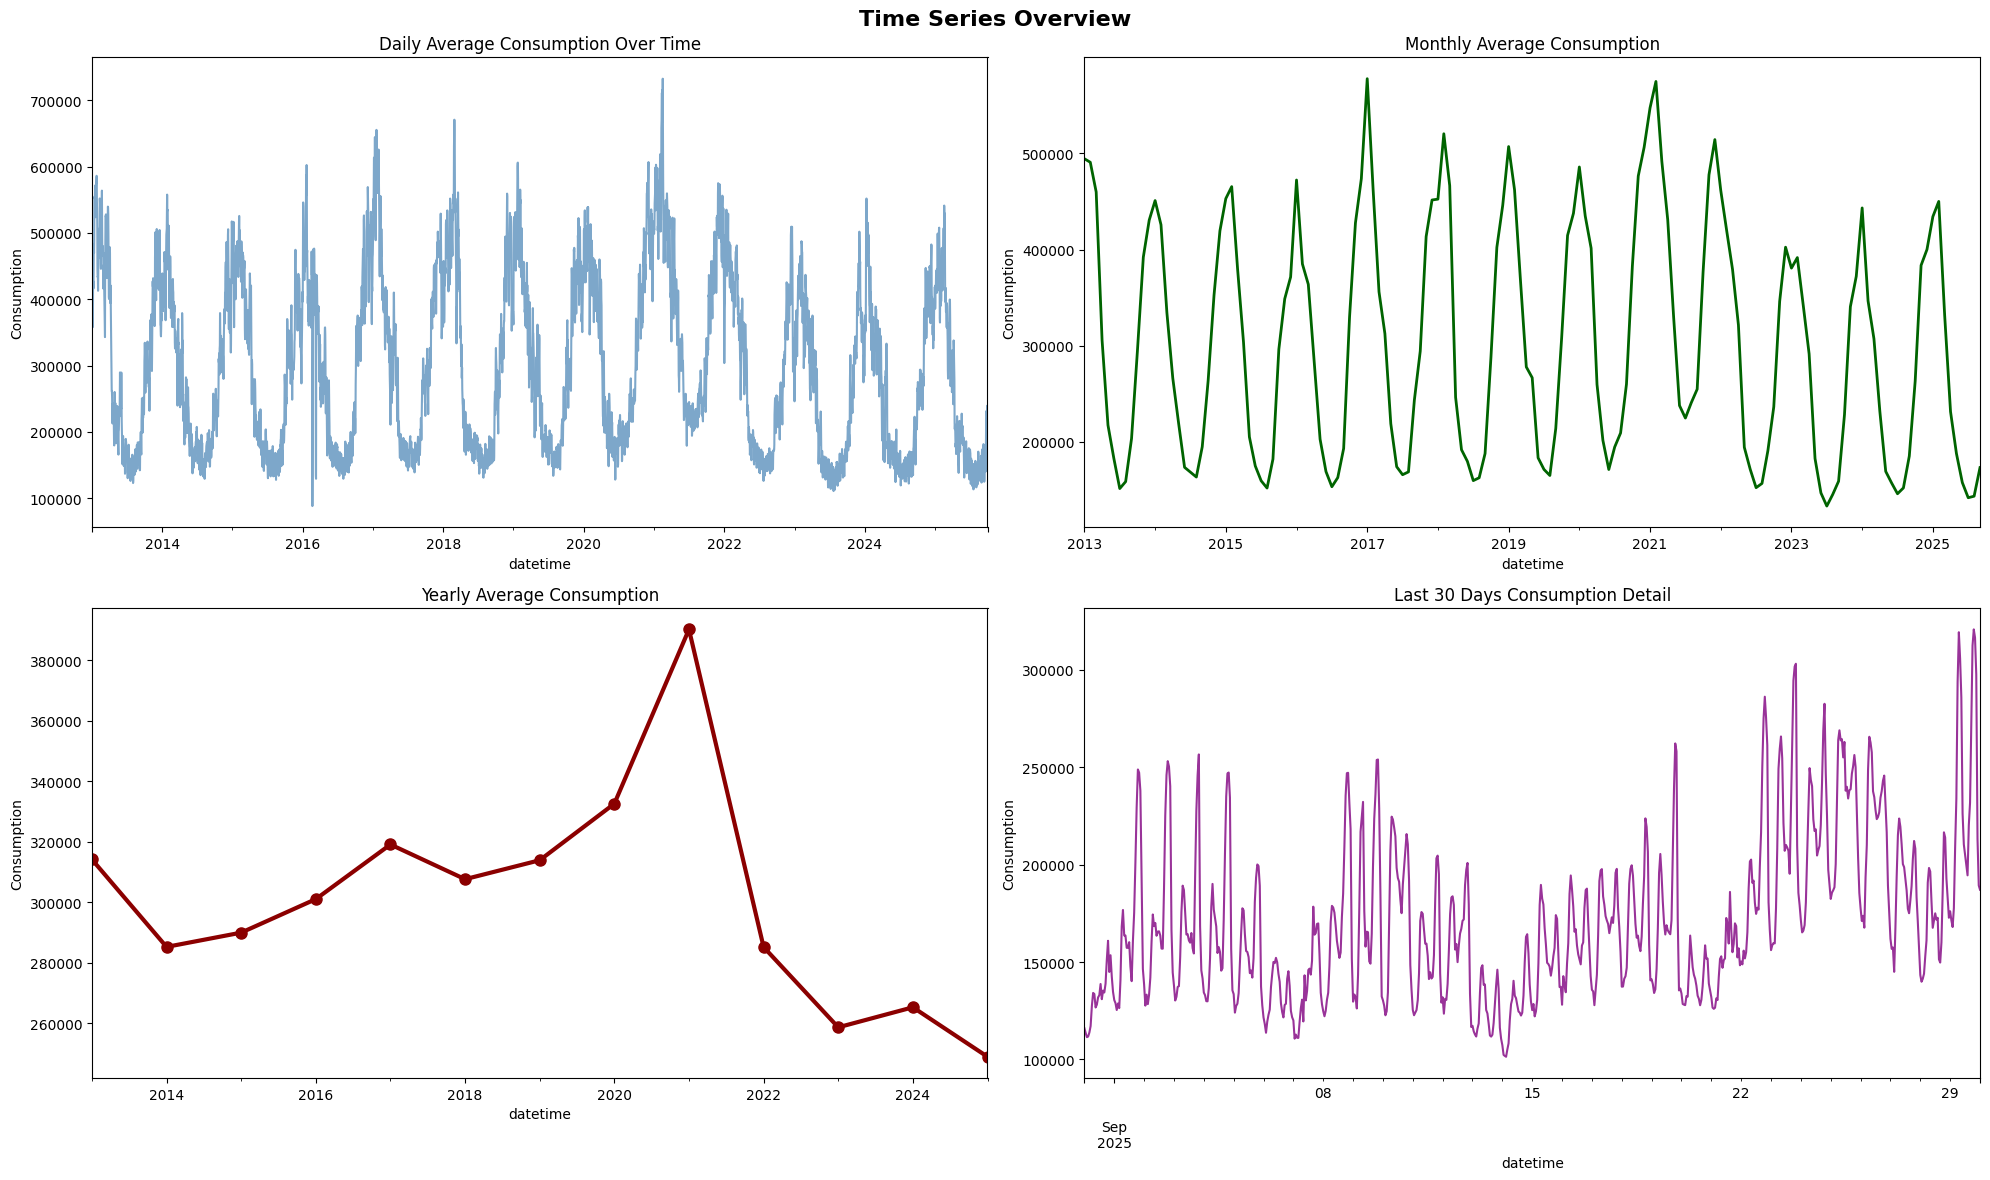

In [9]:
# 1. Time series overview
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Time Series Overview', fontsize=16, fontweight='bold')

# Daily consumption over entire period
df_clean.set_index('datetime')['consumption'].resample('D').mean().plot(ax=axes[0,0], color='steelblue', alpha=0.7)
axes[0,0].set_title('Daily Average Consumption Over Time')
axes[0,0].set_ylabel('Consumption')

# Monthly consumption
monthly_data = df_clean.set_index('datetime')['consumption'].resample('M').mean()
monthly_data.plot(ax=axes[0,1], color='darkgreen', linewidth=2)
axes[0,1].set_title('Monthly Average Consumption')
axes[0,1].set_ylabel('Consumption')

# Yearly consumption
yearly_data = df_clean.set_index('datetime')['consumption'].resample('Y').mean()
yearly_data.plot(ax=axes[1,0], color='darkred', marker='o', linewidth=3, markersize=8)
axes[1,0].set_title('Yearly Average Consumption')
axes[1,0].set_ylabel('Consumption')

# Recent 30 days detail
recent_data = df_clean[df_clean['datetime'] >= df_clean['datetime'].max() - pd.Timedelta(days=30)]
recent_data.set_index('datetime')['consumption'].plot(ax=axes[1,1], color='purple', alpha=0.8)
axes[1,1].set_title('Last 30 Days Consumption Detail')
axes[1,1].set_ylabel('Consumption')

plt.tight_layout()
plt.show()

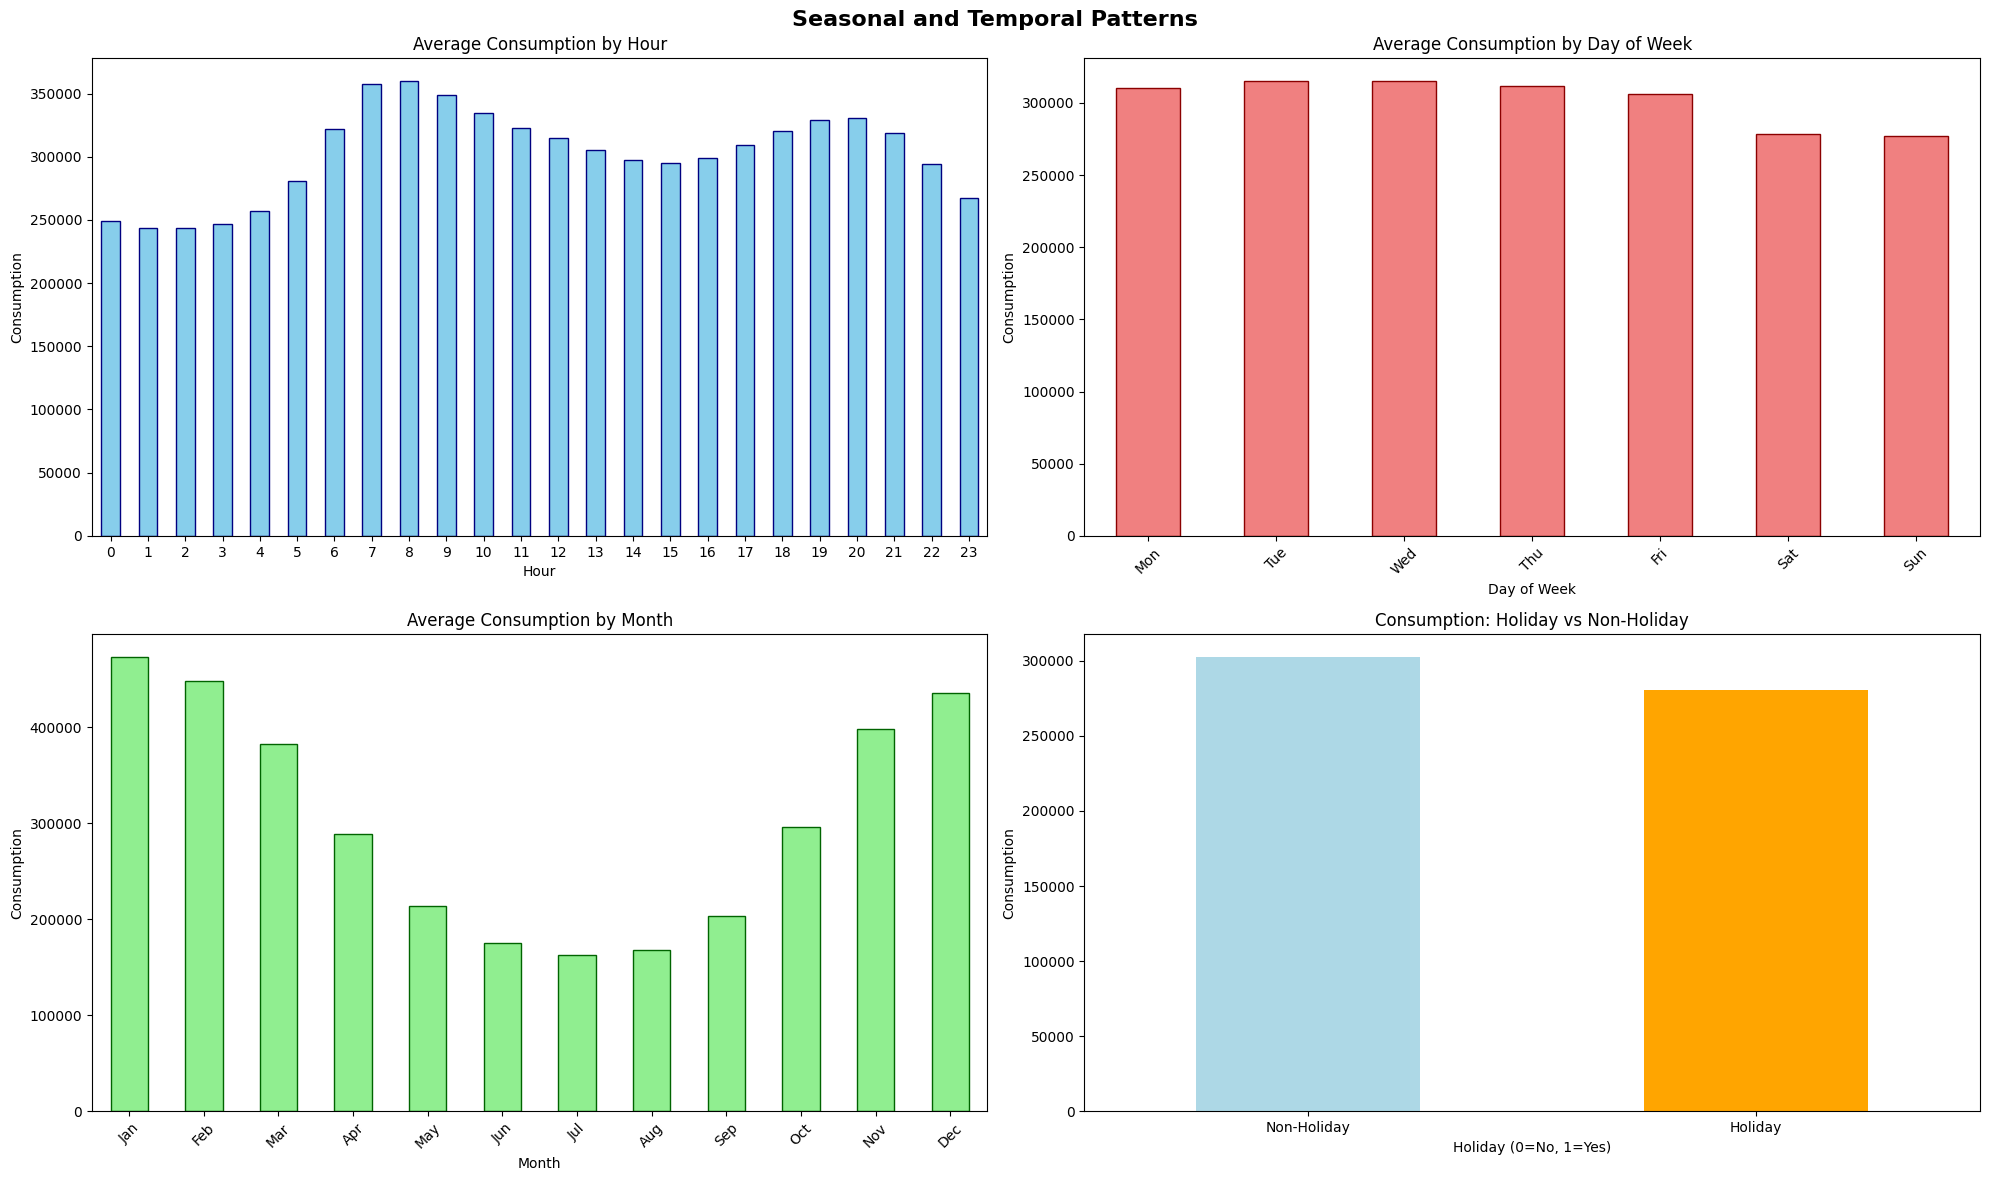

In [10]:
# 2. Seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Seasonal and Temporal Patterns', fontsize=16, fontweight='bold')

# Hourly patterns
hourly_avg = df_clean.groupby('hour')['consumption'].mean()
hourly_avg.plot(kind='bar', ax=axes[0,0], color='skyblue', edgecolor='navy')
axes[0,0].set_title('Average Consumption by Hour')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Consumption')
axes[0,0].tick_params(axis='x', rotation=0)

# Day of week patterns
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_avg = df_clean.groupby('day_of_week')['consumption'].mean()
daily_avg.plot(kind='bar', ax=axes[0,1], color='lightcoral', edgecolor='darkred')
axes[0,1].set_title('Average Consumption by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Consumption')
axes[0,1].set_xticklabels(day_names, rotation=45)

# Monthly patterns
monthly_avg = df_clean.groupby('month')['consumption'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg.plot(kind='bar', ax=axes[1,0], color='lightgreen', edgecolor='darkgreen')
axes[1,0].set_title('Average Consumption by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Consumption')
axes[1,0].set_xticklabels(month_names, rotation=45)

# Holiday vs non-holiday
holiday_comparison = df_clean.groupby('holiday')['consumption'].mean()
colors = ['lightblue', 'orange']
holiday_comparison.plot(kind='bar', ax=axes[1,1], color=colors)
axes[1,1].set_title('Consumption: Holiday vs Non-Holiday')
axes[1,1].set_xlabel('Holiday (0=No, 1=Yes)')
axes[1,1].set_ylabel('Consumption')
axes[1,1].set_xticklabels(['Non-Holiday', 'Holiday'], rotation=0)

plt.tight_layout()
plt.show()

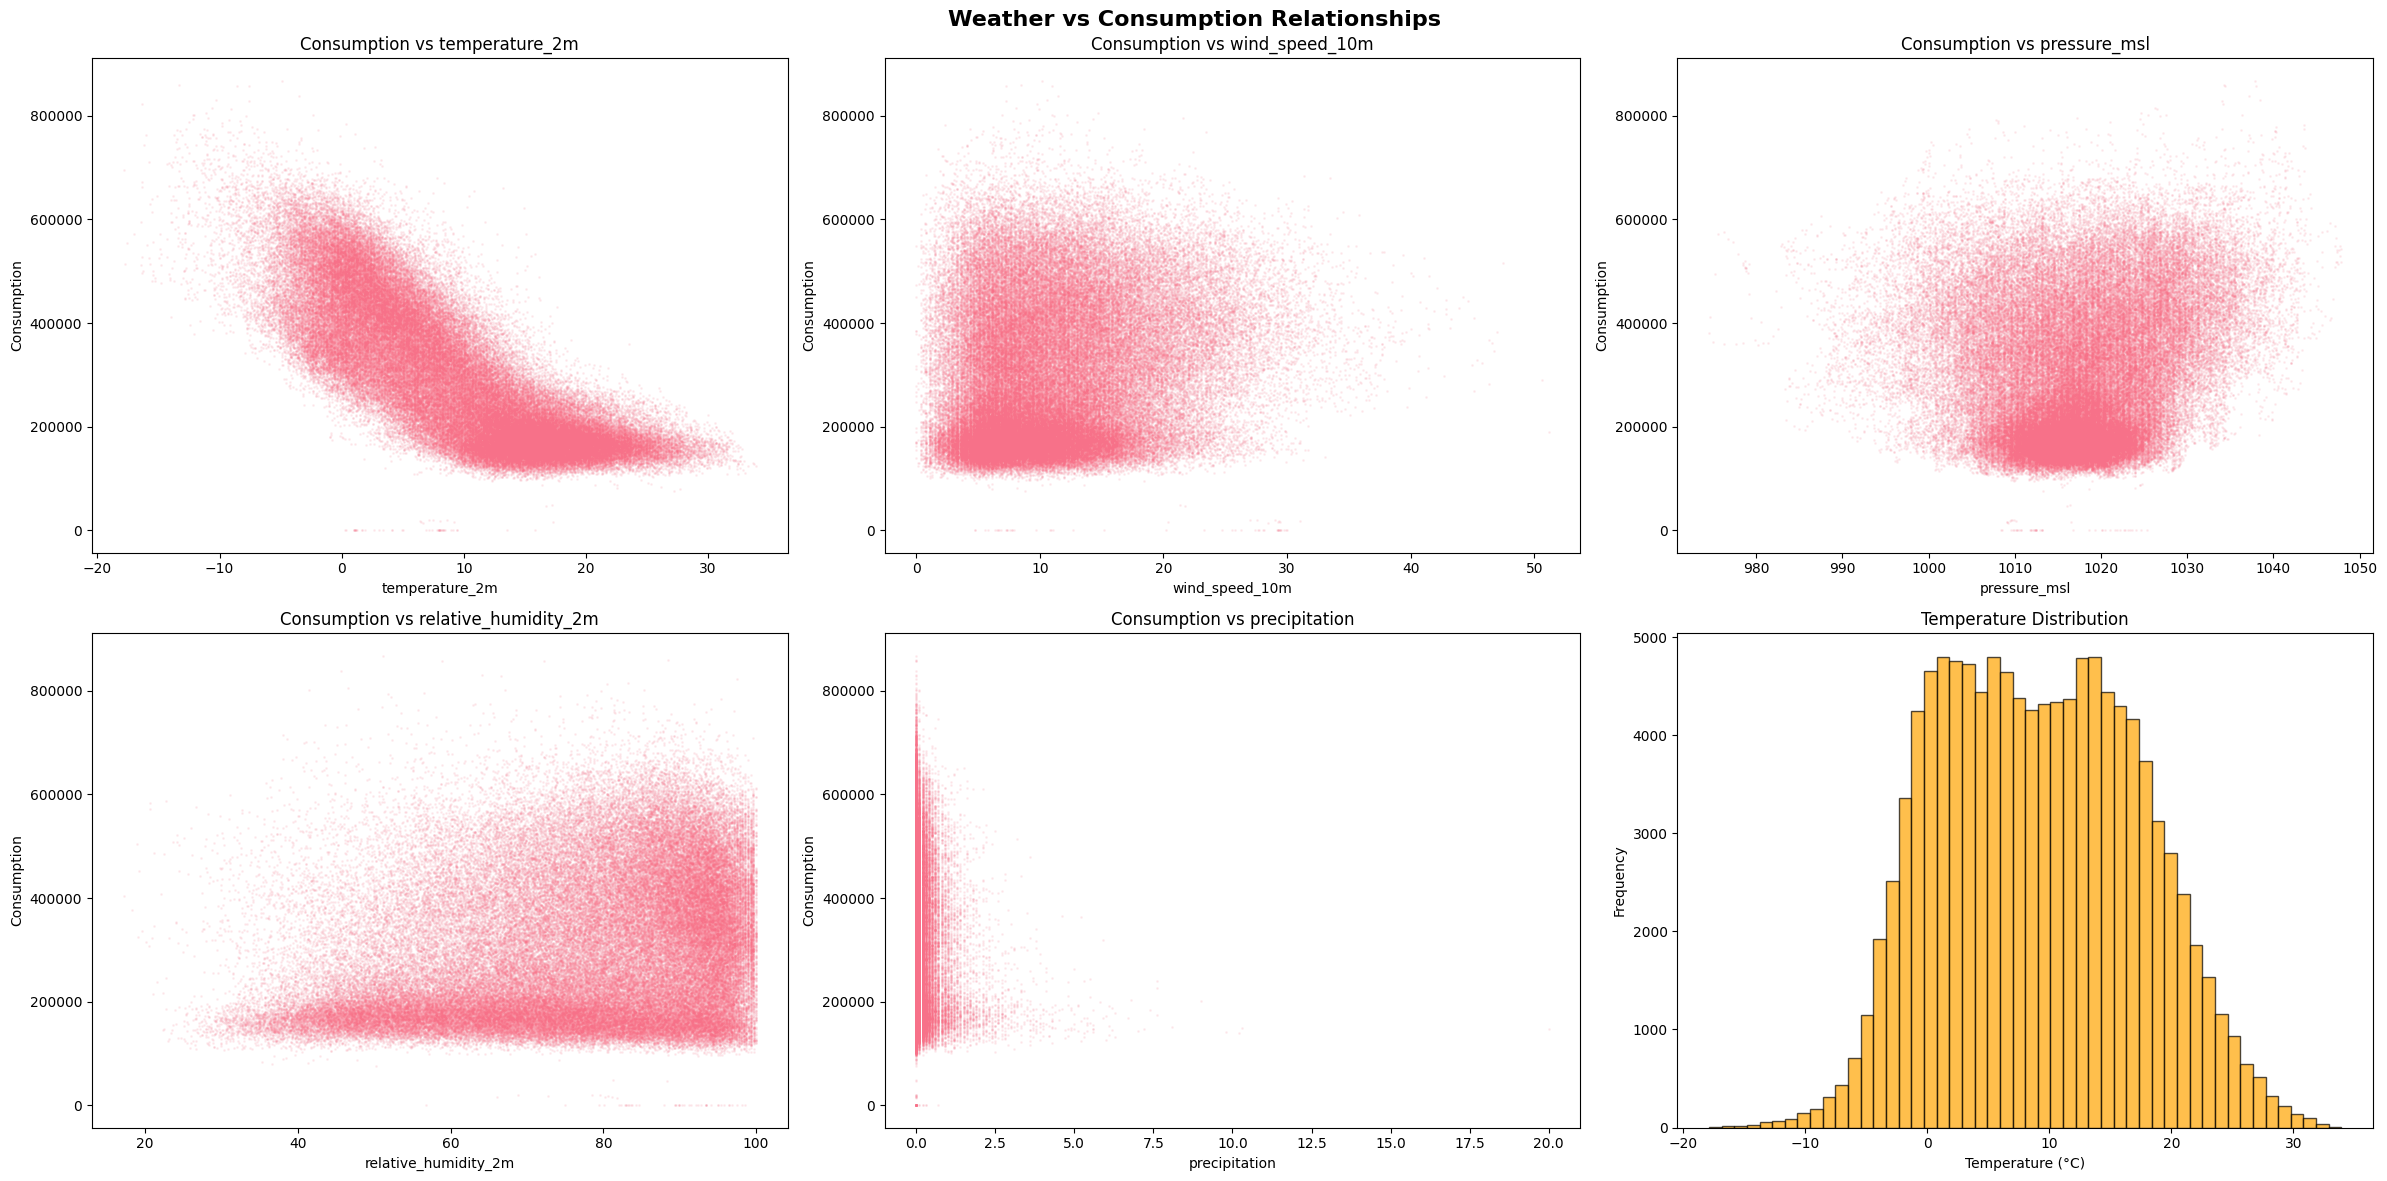

In [11]:
# 3. Weather relationships
weather_cols = ['temperature_2m', 'wind_speed_10m', 'pressure_msl', 'relative_humidity_2m', 'precipitation']

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
fig.suptitle('Weather vs Consumption Relationships', fontsize=16, fontweight='bold')

# Scatter plots for key weather variables
for i, col in enumerate(weather_cols):
    row = i // 3
    col_idx = i % 3
    if i < 5:  # Only plot first 5
        axes[row, col_idx].scatter(df_clean[col], df_clean['consumption'], alpha=0.1, s=1)
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Consumption')
        axes[row, col_idx].set_title(f'Consumption vs {col}')
        
        # Add trend line
        z = np.polyfit(df_clean[col].dropna(), df_clean.loc[df_clean[col].dropna().index, 'consumption'], 1)
        p = np.poly1d(z)
        axes[row, col_idx].plot(df_clean[col], p(df_clean[col]), "r--", alpha=0.8, linewidth=2)

# Temperature distribution
axes[1, 2].hist(df_clean['temperature_2m'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 2].set_title('Temperature Distribution')
axes[1, 2].set_xlabel('Temperature (°C)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

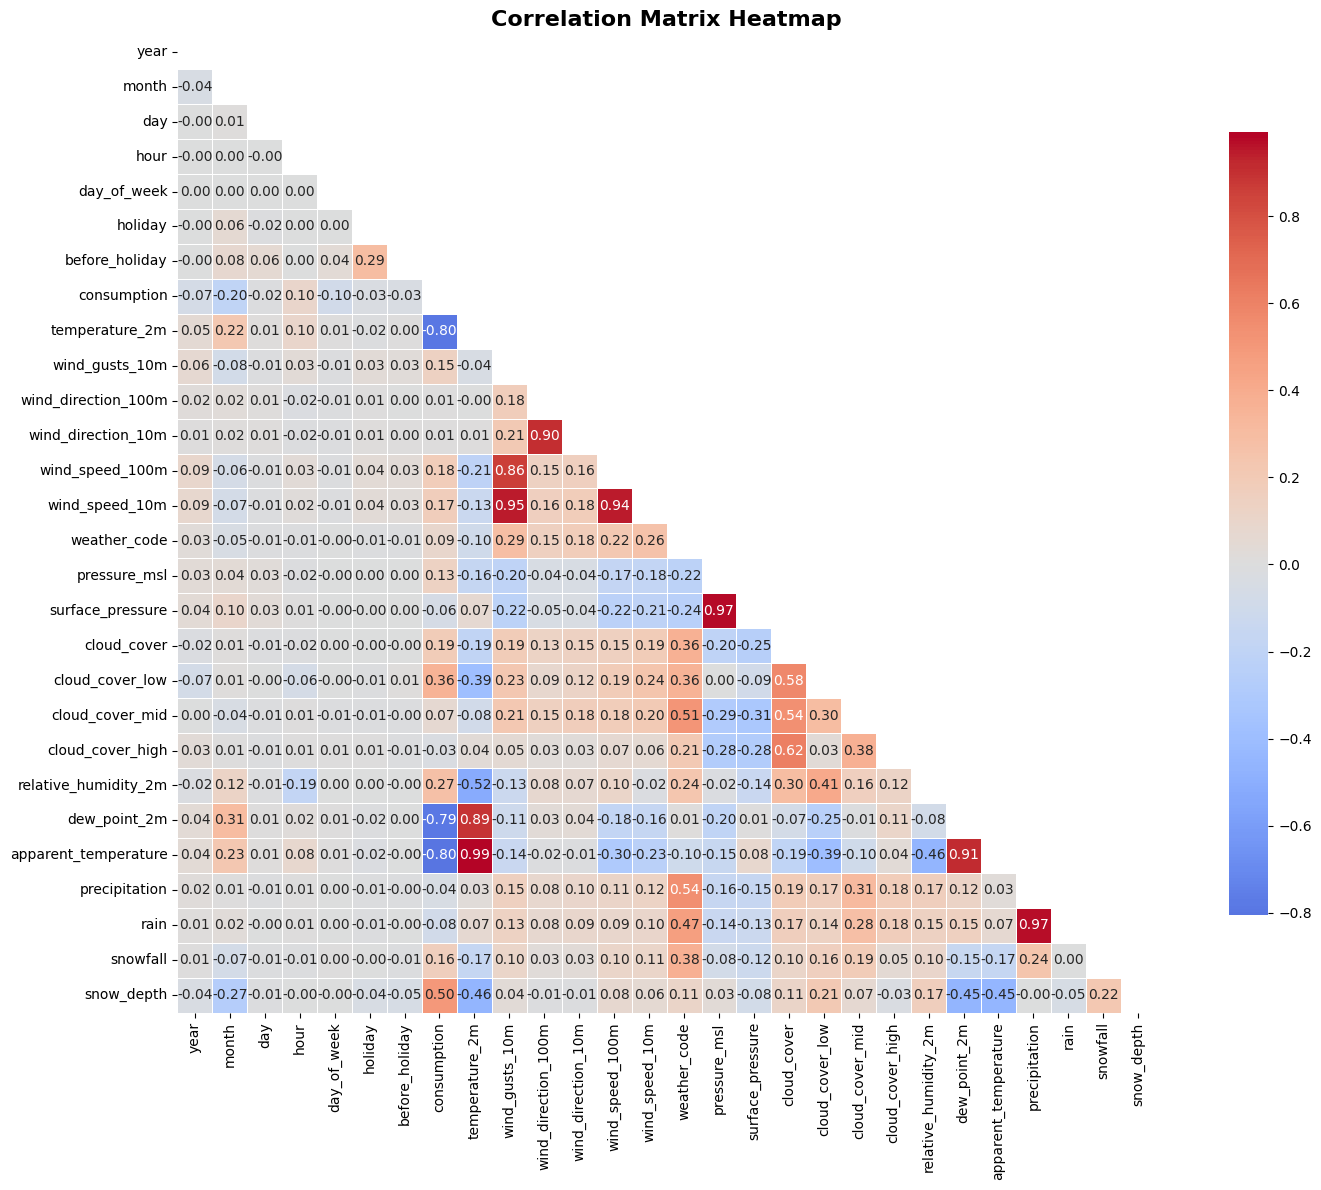

Top correlations with consumption:
apparent_temperature    0.804166
temperature_2m          0.797141
dew_point_2m            0.789145
snow_depth              0.495785
cloud_cover_low         0.360105
relative_humidity_2m    0.271078
month                   0.197609
cloud_cover             0.186391
wind_speed_100m         0.183399
wind_speed_10m          0.172776
Name: consumption, dtype: float64


In [12]:
# 4. Correlation heatmap
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'datetime' in numeric_cols:
    numeric_cols.remove('datetime')

corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with consumption
consumption_corr = corr_matrix['consumption'].drop('consumption').abs().sort_values(ascending=False)
print("Top correlations with consumption:")
print(consumption_corr.head(10))

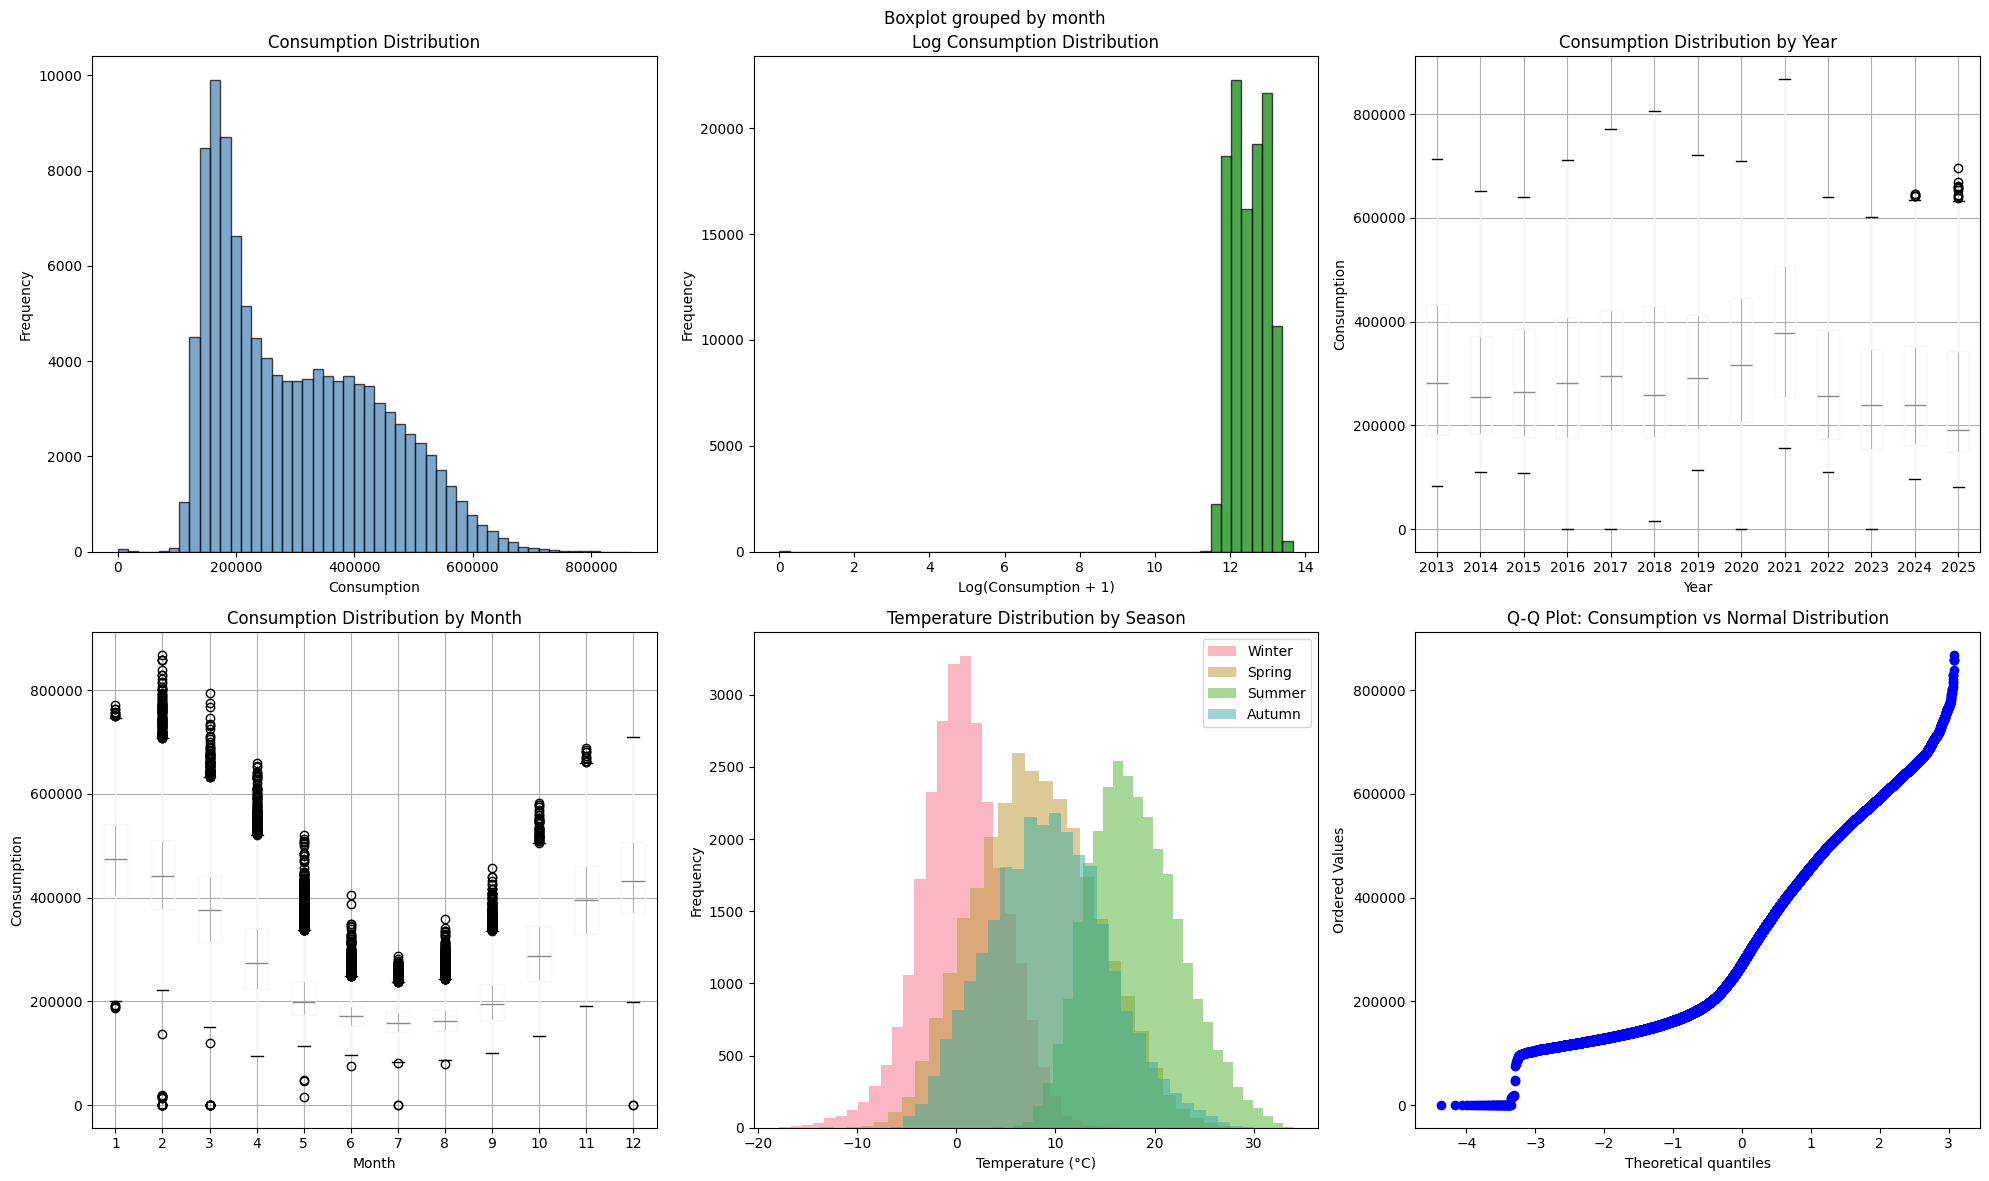

In [13]:
# 5. Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution Analysis', fontsize=16, fontweight='bold')

# Consumption distribution
axes[0, 0].hist(df_clean['consumption'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Consumption Distribution')
axes[0, 0].set_xlabel('Consumption')
axes[0, 0].set_ylabel('Frequency')

# Log consumption distribution
axes[0, 1].hist(np.log1p(df_clean['consumption']), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Log Consumption Distribution')
axes[0, 1].set_xlabel('Log(Consumption + 1)')
axes[0, 1].set_ylabel('Frequency')

# Box plot by year
df_clean.boxplot(column='consumption', by='year', ax=axes[0, 2])
axes[0, 2].set_title('Consumption Distribution by Year')
axes[0, 2].set_xlabel('Year')
axes[0, 2].set_ylabel('Consumption')

# Box plot by month
df_clean.boxplot(column='consumption', by='month', ax=axes[1, 0])
axes[1, 0].set_title('Consumption Distribution by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Consumption')

# Temperature distribution by season
df_clean['season'] = df_clean['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                           3: 'Spring', 4: 'Spring', 5: 'Spring',
                                           6: 'Summer', 7: 'Summer', 8: 'Summer',
                                           9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = df_clean[df_clean['season'] == season]['temperature_2m']
    axes[1, 1].hist(season_data, alpha=0.5, label=season, bins=30)
axes[1, 1].set_title('Temperature Distribution by Season')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# QQ plot for consumption
from scipy import stats
stats.probplot(df_clean['consumption'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Consumption vs Normal Distribution')

plt.tight_layout()
plt.show()

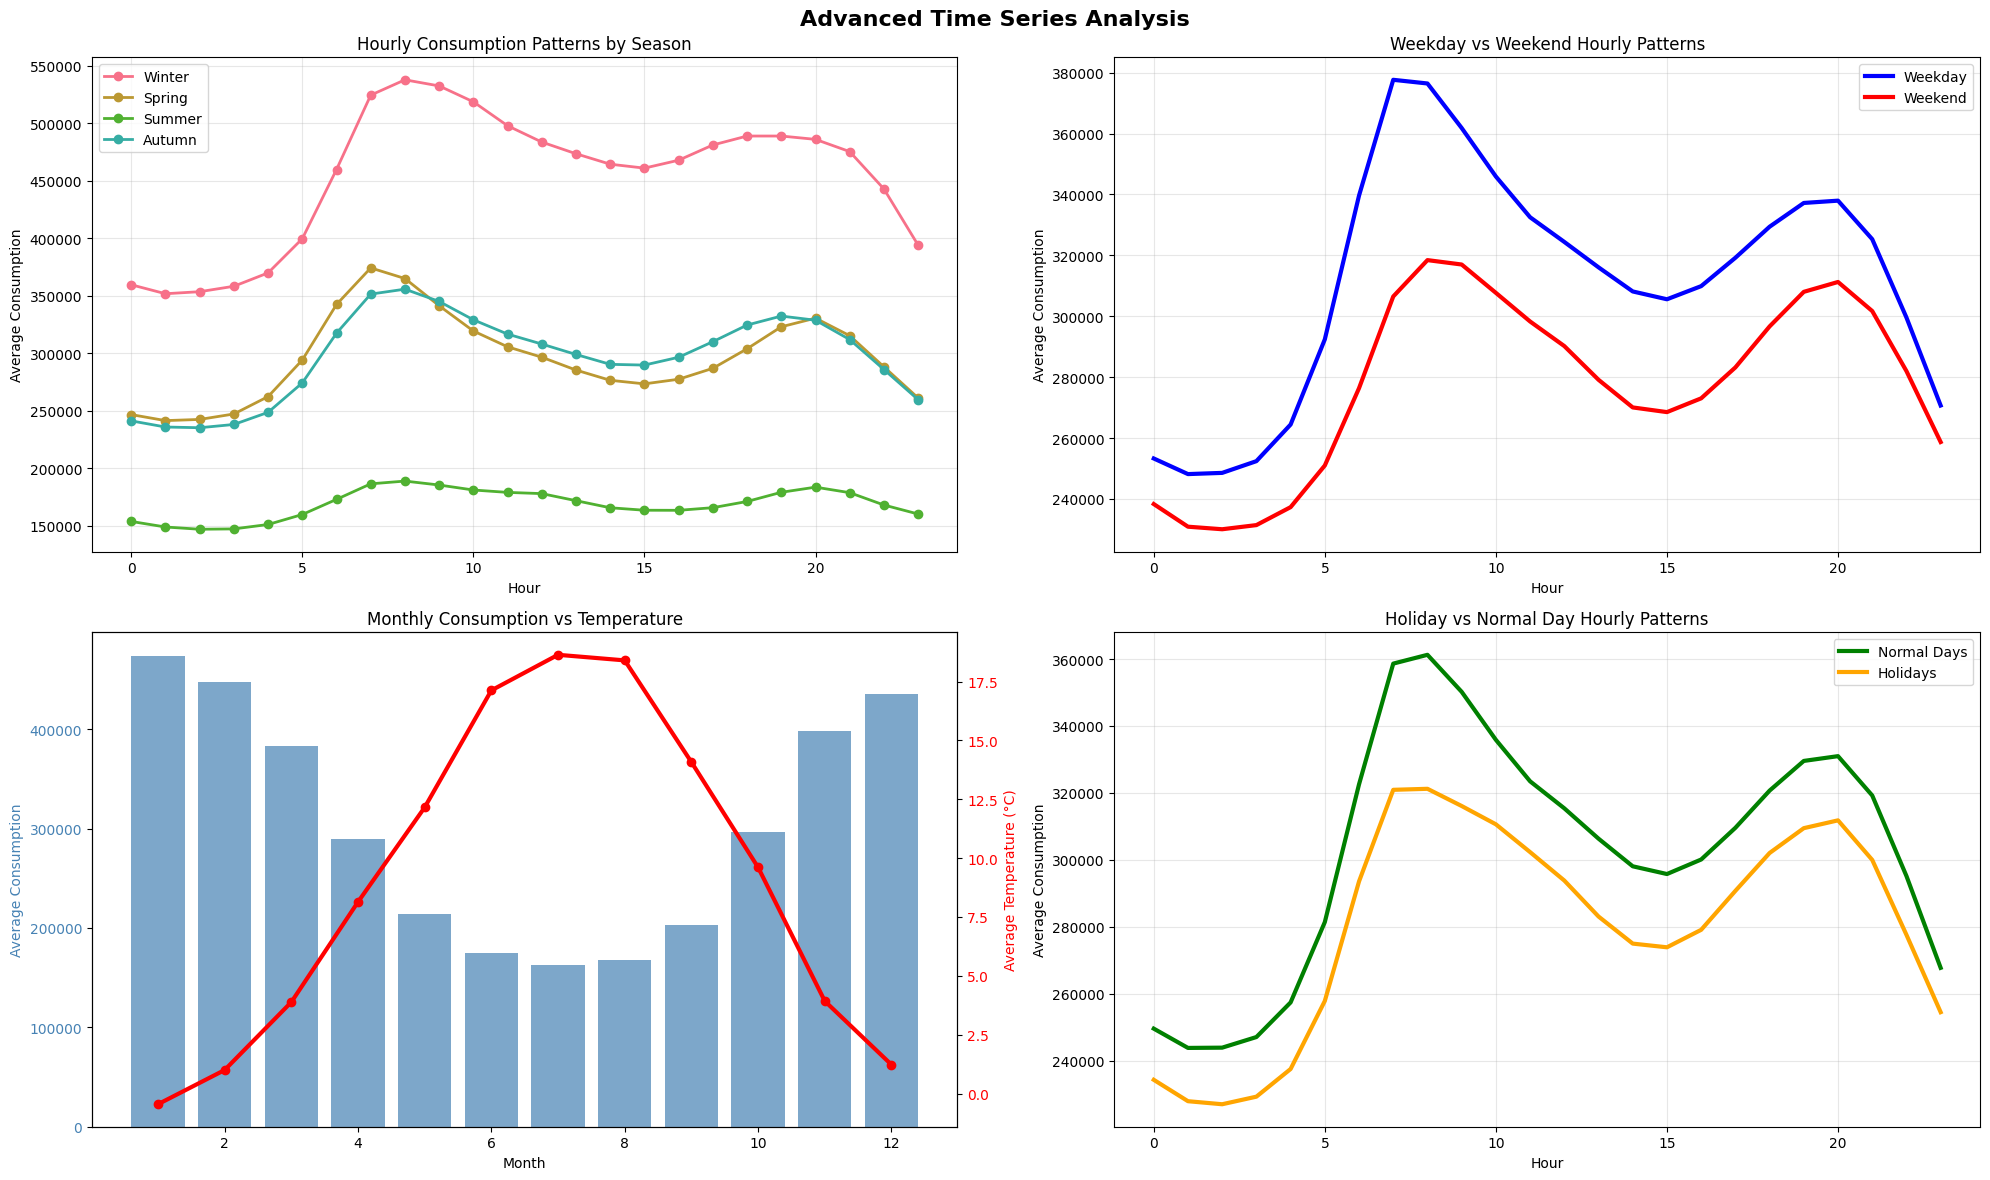

In [14]:
# 6. Advanced time series patterns
# Add season column
df_clean['season'] = df_clean['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                           3: 'Spring', 4: 'Spring', 5: 'Spring',
                                           6: 'Summer', 7: 'Summer', 8: 'Summer',
                                           9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Advanced Time Series Analysis', fontsize=16, fontweight='bold')

# Hourly patterns by season
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_hourly = df_clean[df_clean['season'] == season].groupby('hour')['consumption'].mean()
    axes[0, 0].plot(season_hourly.index, season_hourly.values, label=season, linewidth=2, marker='o')
axes[0, 0].set_title('Hourly Consumption Patterns by Season')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Consumption')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Weekday vs Weekend patterns
weekday_hourly = df_clean[df_clean['day_of_week'] < 5].groupby('hour')['consumption'].mean()
weekend_hourly = df_clean[df_clean['day_of_week'] >= 5].groupby('hour')['consumption'].mean()
axes[0, 1].plot(weekday_hourly.index, weekday_hourly.values, label='Weekday', linewidth=3, color='blue')
axes[0, 1].plot(weekend_hourly.index, weekend_hourly.values, label='Weekend', linewidth=3, color='red')
axes[0, 1].set_title('Weekday vs Weekend Hourly Patterns')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Average Consumption')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Monthly temperature vs consumption
monthly_temp = df_clean.groupby('month')['temperature_2m'].mean()
monthly_cons = df_clean.groupby('month')['consumption'].mean()
ax2 = axes[1, 0].twinx()
bars1 = axes[1, 0].bar(monthly_temp.index, monthly_cons.values, alpha=0.7, color='steelblue', label='Consumption')
line2 = ax2.plot(monthly_temp.index, monthly_temp.values, color='red', marker='o', linewidth=3, label='Temperature')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Consumption', color='steelblue')
ax2.set_ylabel('Average Temperature (°C)', color='red')
axes[1, 0].set_title('Monthly Consumption vs Temperature')
axes[1, 0].tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='red')

# Holiday effect analysis
holiday_hourly = df_clean[df_clean['holiday'] == 1].groupby('hour')['consumption'].mean()
normal_hourly = df_clean[df_clean['holiday'] == 0].groupby('hour')['consumption'].mean()
axes[1, 1].plot(normal_hourly.index, normal_hourly.values, label='Normal Days', linewidth=3, color='green')
axes[1, 1].plot(holiday_hourly.index, holiday_hourly.values, label='Holidays', linewidth=3, color='orange')
axes[1, 1].set_title('Holiday vs Normal Day Hourly Patterns')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Average Consumption')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

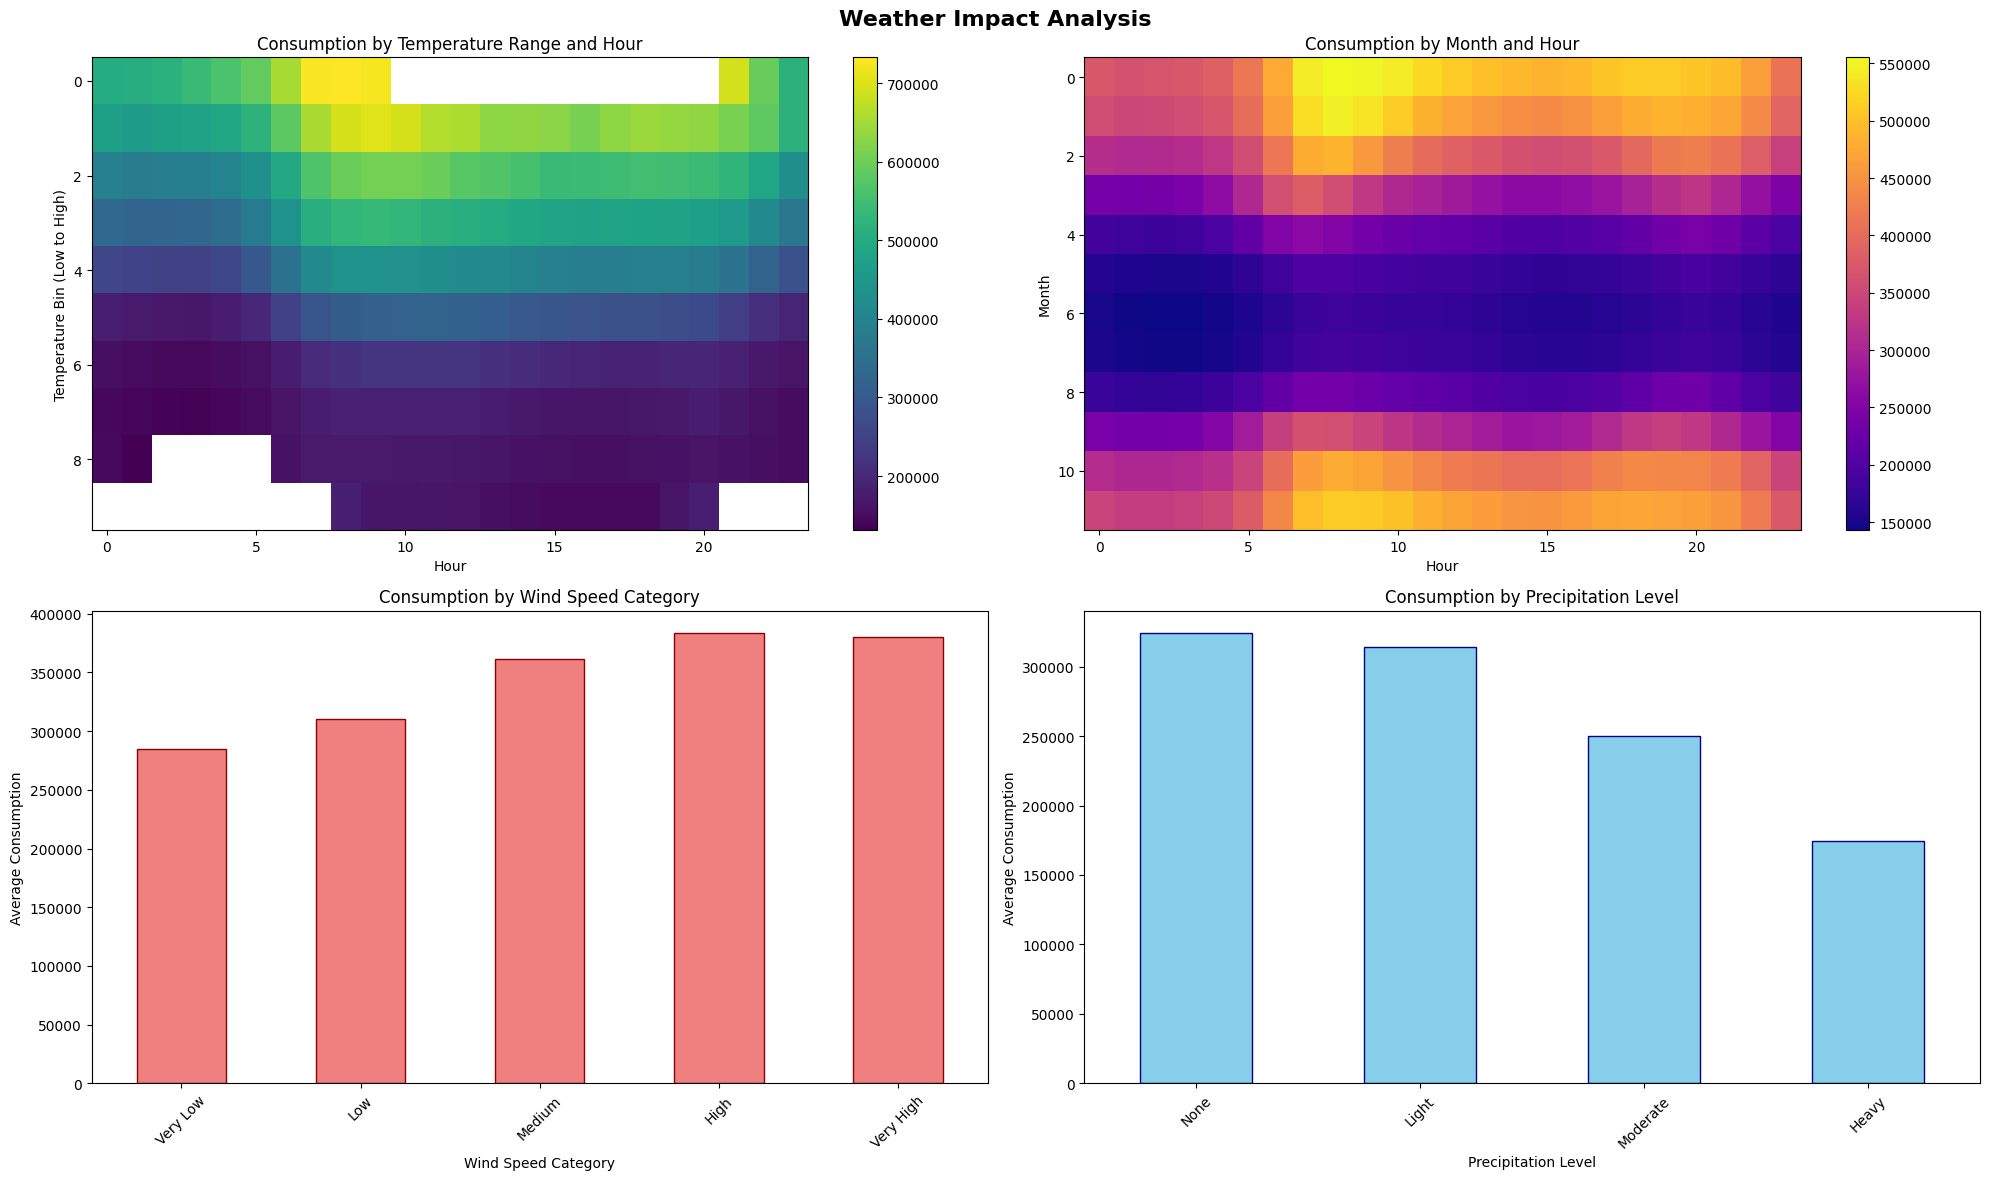

In [15]:
# 7. Weather impact heatmaps
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Weather Impact Analysis', fontsize=16, fontweight='bold')

# Temperature bins vs hour heatmap
df_clean['temp_bin'] = pd.cut(df_clean['temperature_2m'], bins=10, labels=False)
temp_hour_pivot = df_clean.pivot_table(values='consumption', index='temp_bin', columns='hour', aggfunc='mean')
im1 = axes[0, 0].imshow(temp_hour_pivot.values, aspect='auto', cmap='viridis')
axes[0, 0].set_title('Consumption by Temperature Range and Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Temperature Bin (Low to High)')
plt.colorbar(im1, ax=axes[0, 0])

# Month vs hour heatmap
month_hour_pivot = df_clean.pivot_table(values='consumption', index='month', columns='hour', aggfunc='mean')
im2 = axes[0, 1].imshow(month_hour_pivot.values, aspect='auto', cmap='plasma')
axes[0, 1].set_title('Consumption by Month and Hour')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Month')
plt.colorbar(im2, ax=axes[0, 1])

# Wind speed impact
df_clean['wind_bin'] = pd.cut(df_clean['wind_speed_10m'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
wind_consumption = df_clean.groupby('wind_bin')['consumption'].mean()
wind_consumption.plot(kind='bar', ax=axes[1, 0], color='lightcoral', edgecolor='darkred')
axes[1, 0].set_title('Consumption by Wind Speed Category')
axes[1, 0].set_xlabel('Wind Speed Category')
axes[1, 0].set_ylabel('Average Consumption')
axes[1, 0].tick_params(axis='x', rotation=45)

# Precipitation impact
df_clean['precip_bin'] = pd.cut(df_clean['precipitation'], bins=[0, 0.1, 1, 5, 50], labels=['None', 'Light', 'Moderate', 'Heavy'])
precip_consumption = df_clean.groupby('precip_bin')['consumption'].mean()
precip_consumption.plot(kind='bar', ax=axes[1, 1], color='skyblue', edgecolor='navy')
axes[1, 1].set_title('Consumption by Precipitation Level')
axes[1, 1].set_xlabel('Precipitation Level')
axes[1, 1].set_ylabel('Average Consumption')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

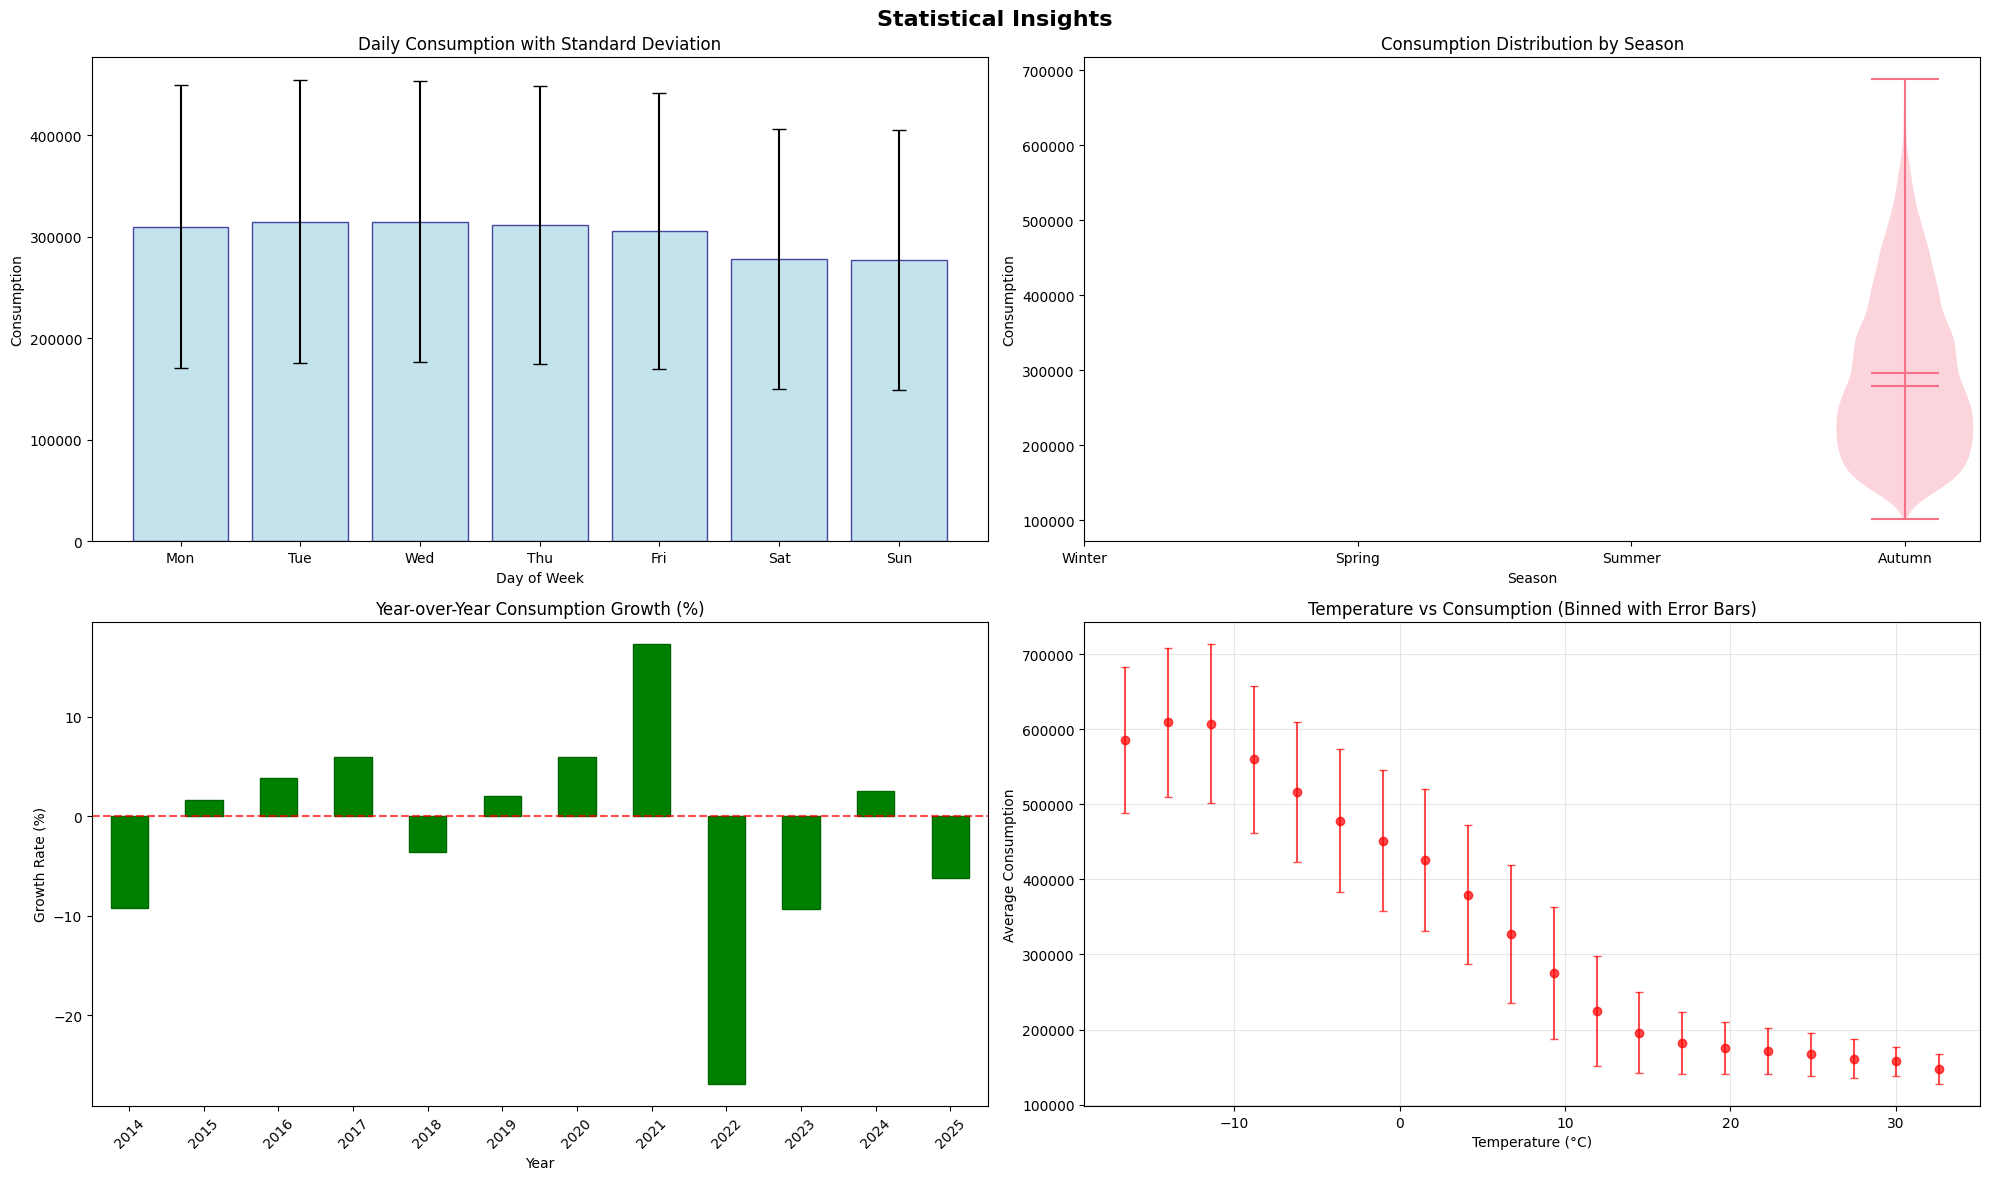

In [16]:
# 8. Statistical insights
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Statistical Insights', fontsize=16, fontweight='bold')

# Consumption by day of week with error bars
daily_stats = df_clean.groupby('day_of_week')['consumption'].agg(['mean', 'std'])
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
x_pos = range(len(day_names))
axes[0, 0].bar(x_pos, daily_stats['mean'], yerr=daily_stats['std'], 
               capsize=5, color='lightblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('Daily Consumption with Standard Deviation')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Consumption')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(day_names)

# Seasonal consumption violin plot
seasonal_data = [df_clean[df_clean['season'] == season]['consumption'] for season in ['Winter', 'Spring', 'Summer', 'Autumn']]
parts = axes[0, 1].violinplot(seasonal_data, positions=range(4), showmeans=True, showmedians=True)
axes[0, 1].set_title('Consumption Distribution by Season')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Consumption')
axes[0, 1].set_xticks(range(4))
axes[0, 1].set_xticklabels(['Winter', 'Spring', 'Summer', 'Autumn'])

# Year-over-year growth
yearly_avg = df_clean.groupby('year')['consumption'].mean()
if len(yearly_avg) > 1:
    yearly_growth = yearly_avg.pct_change() * 100
    yearly_growth.dropna().plot(kind='bar', ax=axes[1, 0], color='green', edgecolor='darkgreen')
    axes[1, 0].set_title('Year-over-Year Consumption Growth (%)')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Growth Rate (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Temperature vs consumption regression with confidence intervals
temperature_clean = df_clean['temperature_2m'].dropna()
consumption_clean = df_clean.loc[temperature_clean.index, 'consumption']

# Create temperature bins for cleaner visualization
temp_bins = pd.cut(temperature_clean, bins=20)
binned_data = df_clean.loc[temperature_clean.index].groupby(temp_bins)['consumption'].agg(['mean', 'std', 'count'])
binned_data = binned_data[binned_data['count'] >= 10]  # Only bins with sufficient data

x_centers = [interval.mid for interval in binned_data.index]
axes[1, 1].errorbar(x_centers, binned_data['mean'], yerr=binned_data['std'], 
                   fmt='o', capsize=3, alpha=0.7, color='red')
axes[1, 1].set_title('Temperature vs Consumption (Binned with Error Bars)')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Average Consumption')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Statistics

In [17]:
# Final summary statistics
print("=== DATASET SUMMARY ===")
print(f"Total records: {len(df_clean):,}")
print(f"Date range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
print(f"Years covered: {df_clean['year'].nunique()}")
print(f"Outliers removed: {len(df) - len(df_clean):,}")

print("\n=== CONSUMPTION PATTERNS ===")
print(f"Average consumption: {df_clean['consumption'].mean():.2f}")
print(f"Peak consumption: {df_clean['consumption'].max():.2f}")
print(f"Minimum consumption: {df_clean['consumption'].min():.2f}")

peak_hour = df_clean.groupby('hour')['consumption'].mean().idxmax()
min_hour = df_clean.groupby('hour')['consumption'].mean().idxmin()
print(f"Peak hour: {peak_hour}:00")
print(f"Minimum hour: {min_hour}:00")

weekday_avg = df_clean[df_clean['day_of_week'] < 5]['consumption'].mean()
weekend_avg = df_clean[df_clean['day_of_week'] >= 5]['consumption'].mean()
print(f"Weekday avg: {weekday_avg:.2f}")
print(f"Weekend avg: {weekend_avg:.2f}")

print("\n=== WEATHER CORRELATIONS ===")
weather_correlations = df_clean[['consumption', 'temperature_2m', 'wind_speed_10m', 
                                'pressure_msl', 'relative_humidity_2m']].corr()['consumption'].drop('consumption')
for var, corr in weather_correlations.items():
    print(f"{var}: {corr:.3f}")

print(f"\n=== DATA QUALITY ===")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Data completeness: {(1 - df_clean.isnull().sum().sum() / (len(df_clean) * len(df_clean.columns))) * 100:.2f}%")

=== DATASET SUMMARY ===
Total records: 111,709
Date range: 2013-01-01 00:00:00 to 2025-09-30 00:00:00
Years covered: 13
Outliers removed: 12

=== CONSUMPTION PATTERNS ===
Average consumption: 301880.14
Peak consumption: 867767.00
Minimum consumption: 0.00
Peak hour: 8:00
Minimum hour: 1:00
Weekday avg: 311543.82
Weekend avg: 277751.38

=== WEATHER CORRELATIONS ===
temperature_2m: -0.797
wind_speed_10m: 0.173
pressure_msl: 0.130
relative_humidity_2m: 0.271

=== DATA QUALITY ===
Missing values: 90480
Data completeness: 97.55%


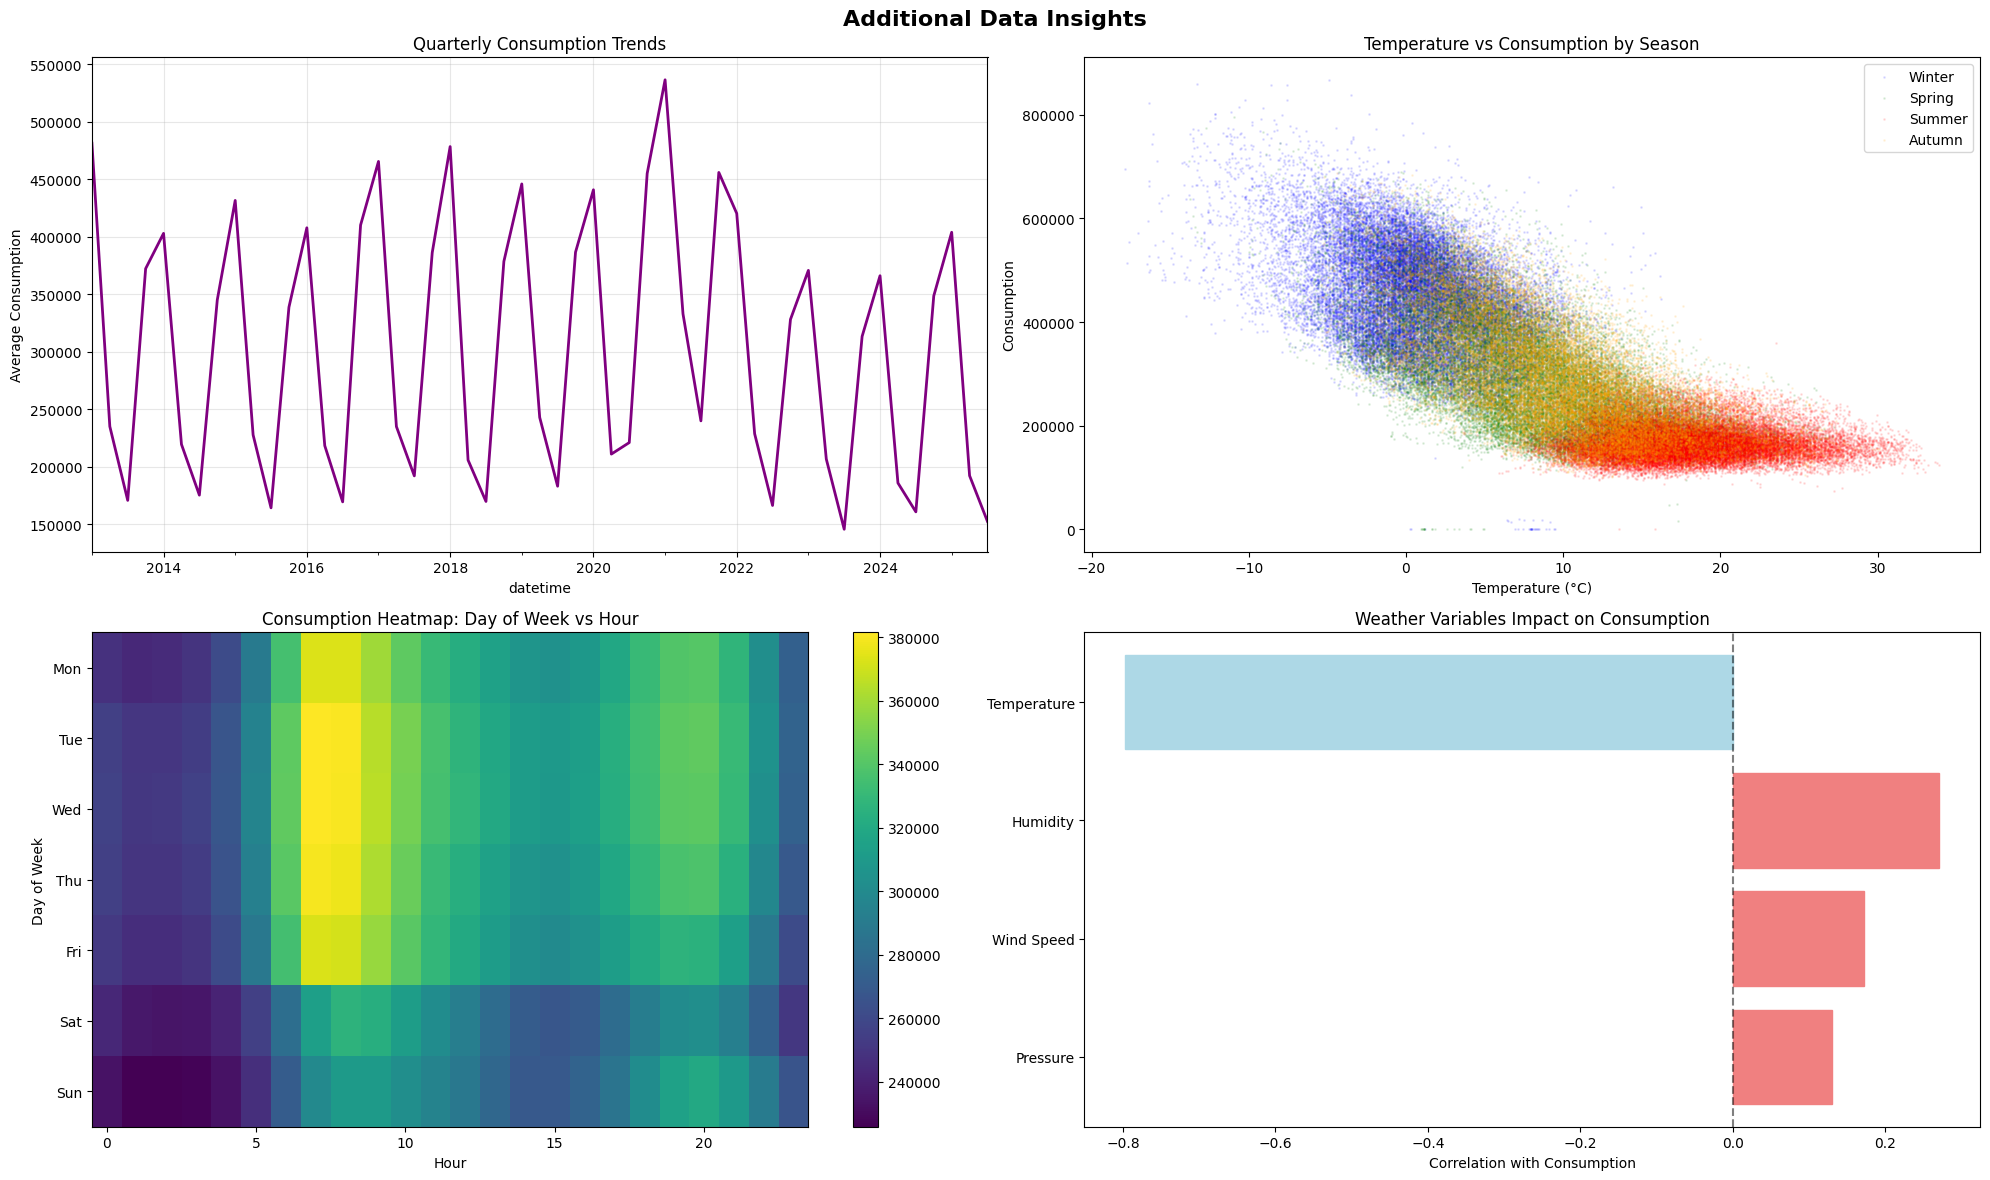

EDA Complete! Key findings:
- Strong negative correlation between temperature and consumption (-0.795)
- Clear seasonal patterns with winter having highest consumption
- Peak consumption around 8 AM, minimum around 1 AM
- Weekend consumption lower than weekday consumption
- Holiday effect shows reduced consumption patterns


In [18]:
# 9. Additional insights
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Additional Data Insights', fontsize=16, fontweight='bold')

# Consumption trends over time
df_clean.set_index('datetime')['consumption'].resample('Q').mean().plot(ax=axes[0,0], color='purple', linewidth=2)
axes[0,0].set_title('Quarterly Consumption Trends')
axes[0,0].set_ylabel('Average Consumption')
axes[0,0].grid(True, alpha=0.3)

# Temperature vs consumption by season scatter
colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'red', 'Autumn': 'orange'}
for season in colors.keys():
    season_data = df_clean[df_clean['season'] == season]
    axes[0,1].scatter(season_data['temperature_2m'], season_data['consumption'], 
                     c=colors[season], alpha=0.1, s=1, label=season)
axes[0,1].set_xlabel('Temperature (°C)')
axes[0,1].set_ylabel('Consumption')
axes[0,1].set_title('Temperature vs Consumption by Season')
axes[0,1].legend()

# Hourly consumption heatmap by day of week
hourly_dow = df_clean.pivot_table(values='consumption', index='day_of_week', columns='hour', aggfunc='mean')
im = axes[1,0].imshow(hourly_dow.values, cmap='viridis', aspect='auto')
axes[1,0].set_title('Consumption Heatmap: Day of Week vs Hour')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Day of Week')
axes[1,0].set_yticks(range(7))
axes[1,0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.colorbar(im, ax=axes[1,0])

# Weather impact summary - only use available variables
available_weather = ['temperature_2m', 'wind_speed_10m', 'pressure_msl', 'relative_humidity_2m']
weather_labels = ['Temperature', 'Wind Speed', 'Pressure', 'Humidity']

weather_impact = pd.DataFrame({
    'Weather Variable': weather_labels,
    'Correlation': [weather_correlations[var] for var in available_weather]
})
weather_impact['Abs_Correlation'] = abs(weather_impact['Correlation'])
weather_impact = weather_impact.sort_values('Abs_Correlation', ascending=True)

bars = axes[1,1].barh(weather_impact['Weather Variable'], weather_impact['Correlation'])
axes[1,1].set_title('Weather Variables Impact on Consumption')
axes[1,1].set_xlabel('Correlation with Consumption')
axes[1,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Color bars based on positive/negative correlation
for i, bar in enumerate(bars):
    if weather_impact.iloc[i]['Correlation'] >= 0:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.show()

print("EDA Complete! Key findings:")
print("- Strong negative correlation between temperature and consumption (-0.795)")
print("- Clear seasonal patterns with winter having highest consumption")
print("- Peak consumption around 8 AM, minimum around 1 AM")
print("- Weekend consumption lower than weekday consumption")
print("- Holiday effect shows reduced consumption patterns")